# Gender prediction on Titanic dataset with Neural network

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer,KNNImputer 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers
from tensorflow.keras import models
from keras_tuner.tuners import RandomSearch
from plot_keras_history import plot_history

In [3]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data exploration

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
data.isnull().sum().sort_values(ascending=False)/len(data) #checking for null or Nan in %

<AxesSubplot:ylabel='Frequency'>

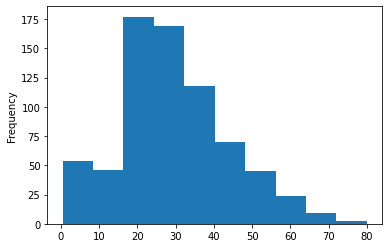

In [5]:
data["Age"].plot(kind = 'hist') # checking for normal distribution of Age column

## Data Cleaning

In [6]:
#impute with KNN a simpleImpute


imputer = KNNImputer(n_neighbors=3)         
imputer.fit_transform(data[["Age"]])
data["Age"] = imputer.transform(data[["Age"]])


imputer = SimpleImputer(strategy="most_frequent")
imputer.fit_transform(data[["Embarked"]])
data["Embarked"] = imputer.transform(data[["Embarked"]])

In [ ]:
data.isnull().sum().sort_values(ascending=False)/len(data) # doublecheck if imputer worked as desired

In [7]:
data["Embarked"].value_counts() # checking of cathegorical values

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
## Scaling Fare and Age

<AxesSubplot:ylabel='Frequency'>

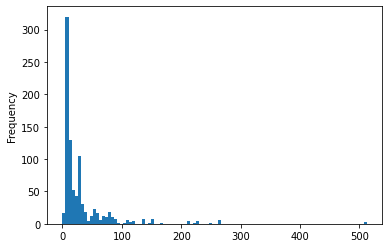

In [9]:
data["Fare"].plot(kind="hist",bins=100)

<AxesSubplot:ylabel='Frequency'>

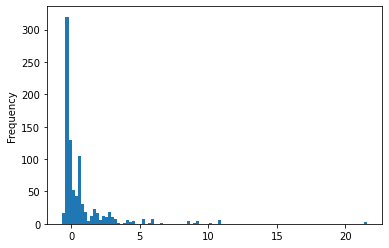

In [10]:
robustscaler = RobustScaler()
data["Fare"] = robustscaler.fit_transform(data[["Fare"]])
data["Fare"].plot(kind="hist",bins=100)

<AxesSubplot:ylabel='Frequency'>

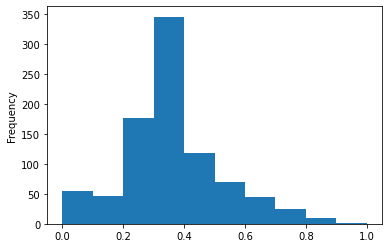

In [11]:
minmaxscaler = MinMaxScaler()
data["Age"] = minmaxscaler.fit_transform(data[["Age"]])
data["Age"].plot(kind = 'hist')

## One hot encode of numerical values

In [12]:
ohe_Pclass = OneHotEncoder(sparse = False) 

ohe_Pclass.fit(data[['Pclass']]) 

Pclass_encoded = ohe_Pclass.transform(data[['Pclass']]) 

data["1_Pclass"],data["2_Pclass"],data['3_Pclass'] = Pclass_encoded.T 


In [13]:
ohe_Parch = OneHotEncoder(sparse = False) 

ohe_Parch.fit(data[['Parch']]) 

Parch_encoded = ohe_Parch.transform(data[['Parch']]) 

data["1_Parch"],data["2_Parch"],data['3_Parch'],data['3_Parch'],data['3_Parch'],data['3_Parch'],data['3_Parch'] = Parch_encoded.T 


In [14]:
ohe_Embarked = OneHotEncoder(sparse = False) 

ohe_Embarked.fit(data[['Embarked']]) 

Embarked_encoded = ohe_Embarked.transform(data[['Embarked']]) 

data["S_Embarked"],data["C_Embarked"],data['Q_Embarked'] = Embarked_encoded.T 

In [15]:
ohe_SibSp = OneHotEncoder(sparse = False) 

ohe_SibSp.fit(data[['SibSp']]) 

SibSp_encoded = ohe_SibSp.transform(data[['SibSp']]) 

data["0_SibSp"],data["1_SibSp"],data['2_SibSp'],data['4_SibSp'],data['3_SibSp'],data['8_SibSp'],data['5_SibSp'] = SibSp_encoded.T 

In [16]:
data_1 = data.drop(columns=["Pclass", "Embarked","SibSp", "Parch"], axis=1) #dropping encoded columns

In [17]:
data_1

,PassengerId,Survived,Name,Sex,Age,Ticket,Fare,Cabin,1_Pclass,2_Pclass,...,S_Embarked,C_Embarked,Q_Embarked,0_SibSp,1_SibSp,2_SibSp,4_SibSp,3_SibSp,8_SibSp,5_SibSp
0,1,0,"Braund, Mr. Owen Harris",male,0.271174,A/5 21171,-0.312011,NaN,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.472229,PC 17599,2.461242,C85,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1,"Heikkinen, Miss. Laina",female,0.321438,STON/O2. 3101282,-0.282777,NaN,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.434531,113803,1.673732,C123,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0,"Allen, Mr. William Henry",male,0.434531,373450,-0.277363,NaN,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",male,0.334004,211536,-0.062981,NaN,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
887,888,1,"Graham, Miss. Margaret Edith",female,0.233476,112053,0.673281,B42,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,0.367921,W./C. 6607,0.389604,NaN,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
889,890,1,"Behr, Mr. Karl Howell",male,0.321438,111369,0.673281,C148,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
X = data_1.drop(columns=['Sex',"Cabin","Name","Ticket", "PassengerId"], axis =1)
y = data_1["Sex"]
X

,Survived,Age,Fare,1_Pclass,2_Pclass,3_Pclass,1_Parch,2_Parch,3_Parch,S_Embarked,C_Embarked,Q_Embarked,0_SibSp,1_SibSp,2_SibSp,4_SibSp,3_SibSp,8_SibSp,5_SibSp
0,0,0.271174,-0.312011,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.472229,2.461242,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0.321438,-0.282777,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.434531,1.673732,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,0.434531,-0.277363,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.334004,-0.062981,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
887,1,0.233476,0.673281,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0,0.367921,0.389604,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
889,1,0.321438,0.673281,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
y = y.map({"female":0, "male":1}) # label encodeing

In [20]:
X = X.reset_index(drop=True)  # index reset

In [21]:
#hold out method for spliting up the dataset

X_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42) 
len(X.columns)

19

## Keras tuner

In [22]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=512,
                                            step=16),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['accuracy'])
    return model

In [24]:
#tuner params
tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=5,
    executions_per_trial=5,
    directory='project',
    project_name='Index7')


INFO:tensorflow:Reloading Oracle from existing project project/Index7/oracle.json
INFO:tensorflow:Reloading Tuner from project/Index7/tuner0.json


In [25]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 16, 'sampling': None}
units_6 (Int)
{'default': None, 'conditio

In [26]:
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(x_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [27]:
tuner.results_summary() 

Results summary
Results in project/Index7
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 7
units_0: 264
units_1: 232
learning_rate: 0.0001
units_2: 72
units_3: 344
units_4: 312
units_5: 152
units_6: 168
units_7: 248
Score: 0.8311797857284546
Trial summary
Hyperparameters:
num_layers: 8
units_0: 392
units_1: 264
learning_rate: 0.0001
units_2: 136
units_3: 280
units_4: 40
units_5: 360
units_6: 136
units_7: 392
Score: 0.8283707857131958
Trial summary
Hyperparameters:
num_layers: 6
units_0: 264
units_1: 152
learning_rate: 0.001
units_2: 8
units_3: 8
units_4: 8
units_5: 8
Score: 0.8272471904754639
Trial summary
Hyperparameters:
num_layers: 8
units_0: 376
units_1: 104
learning_rate: 0.01
units_2: 424
units_3: 152
units_4: 232
units_5: 88
units_6: 8
units_7: 8
Score: 0.6764044880867004
Trial summary
Hyperparameters:
num_layers: 4
units_0: 296
units_1: 104
learning_rate: 0.01
units_2: 344
units_3: 312
units_4: 392
units_5: 120
Scor

## Using early stop for fine tuning

In [28]:
def initialize_model():   
    model = models.Sequential()
    model.add(layers.Dense(264, activation='relu', input_dim = X_train.shape[-1])) 
    model.add(layers.Dense(232, activation='relu'))
    model.add(layers.Dense(72, activation='relu'))
    model.add(layers.Dense(344, activation='relu'))
    model.add(layers.Dense(312, activation='relu'))
    model.add(layers.Dense(152, activation='relu'))
    model.add(layers.Dense(168, activation='relu'))
    model.add(layers.Dense(248, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [29]:
def compile_model(model, optimizer_name):
    
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = optimizer_name,
                  metrics = "accuracy")
    
    return model

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

model = compile_model(initialize_model(), 'adam')

es = EarlyStopping(patience =20,
                   restore_best_weights = True)

history = model.fit(X_train, 
                    y_train, 
                    validation_split = 0.25,
                    shuffle = True,
                    batch_size =8, 
                    epochs = 1000, 
                    callbacks = [es], 
                    verbose=0)

res = model.evaluate(x_test, y_test)[1]
res


6/6 [==============================] - 0s 2ms/step - loss: 0.4937 - accuracy: 0.8212


0.8212290406227112

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

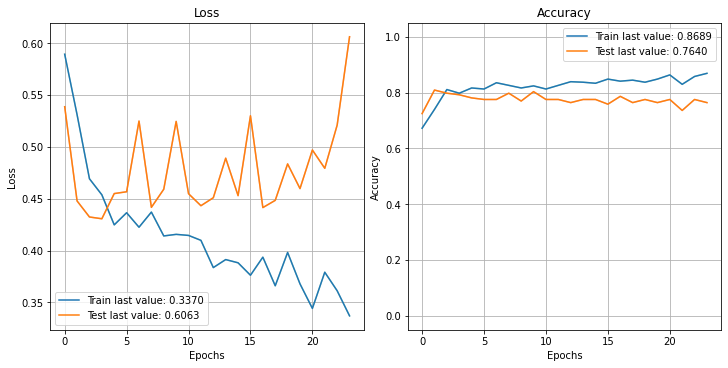

In [31]:
plot_history(history)